In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0")

In [197]:
# Learning settings
LEARNING_RATE = 0.1
DISCOUNT = 0.95

EPISODES = 25000
SHOW_EVERY = EPISODES
STATS_EVERY = 200
SAVE_EVERY = EPISODES//1000

DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [ ]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [201]:
def plot(dict_x_ys_labels):
    x = dict_x_ys_labels["x"]
    ys = dict_x_ys_labels["ys"]
    labels = dict_x_ys_labels["labels"]
    min_len = min(len(ys), len(labels))

    if(len(ys) != len(labels)):
        print("warnig plot: len of ys and labels differents")

    for i in range(min_len):
        plt.plot(x, ys[i], label=labels[i])
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

In [198]:

# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

for episode in range(1,EPISODES + 1):
    episode_reward = 0

    state = env.reset()
    discrete_state = get_discrete_state(state)

    if episode % SHOW_EVERY == 0:
        print("goal count% : ", goal_count/SHOW_EVERY)
        goal_count = 0
        print(episode)

    done = False
    while not done:

        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(q_table[discrete_state])
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)

        new_state, reward, done, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)

        episode_reward += reward

        if episode % SHOW_EVERY == 0:
            env.render()

        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q

        # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
        elif new_state[0] >= env.goal_position:
            #q_table[discrete_state + (action,)] = reward
            q_table[discrete_state + (action,)] = 0

        discrete_state = new_discrete_state

    ep_rewards.append(episode_reward)
    
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
        # print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    env.close()

    if episode % SAVE_EVERY == 0:
        np.save(f"qtables/{episode}-qtable.npy", q_table)

dict_x_ys_labels = {"x": aggr_ep_rewards["ep"], "ys": [aggr_ep_rewards["min"], aggr_ep_rewards["avg"], aggr_ep_rewards["max"]], "labels": ["min rewards", "average rewards", "max rewards"]}
plot(dict_x_ys_labels, fig)


KeyboardInterrupt: 

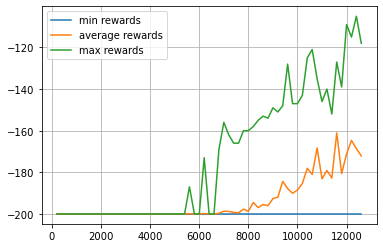

In [202]:
dict_x_ys_labels = {"x": aggr_ep_rewards["ep"], "ys": [aggr_ep_rewards["min"], aggr_ep_rewards["avg"], aggr_ep_rewards["max"]], "labels": ["min rewards", "average rewards", "max rewards"]}
plot(dict_x_ys_labels)